In [3]:
from collections import Counter
import csv
import itertools
import json
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy, skew
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression, LogisticRegression
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from config import (
    USER_EVAL_PATH_2,
    USER_EVAL_PATH_6,
    USER_EVAL_PATH_10,
    RANDOM_STATE,
    RECOMMENDER_EVAL_PATH,
    TRAIN_DATA_PATH,
    RECOMMENDATIONS_PATH,
    RECOMMENDATIONS_KEY_BASELINE,
    RECOMMENDATIONS_KEY_CF,
    RECOMMENDATIONS_KEY_CB_TITLE,
    RECOMMENDATIONS_KEY_CB_DESCR,
    RECOMMENDATIONS_KEY_CB_COMBI,
    RECOMMENDATIONS_KEY_HYBRID,
    MAIN_RESULTS_ANALYSIS_PATH,
    N_RECOMMENDATIONS,
    EVALUATION_METRICS,
    METADATA_PATH,
    TEST_DATA_PATH,
)

### Common data and settings
Loading the necessary data once for all analyses.

In [4]:
# loading user evaluation results
with open("../" + USER_EVAL_PATH_2, "r") as file:
    eval_2_data = json.load(file)

with open("../" + USER_EVAL_PATH_6, "r") as file:
    eval_6_data = json.load(file)

with open("../" + USER_EVAL_PATH_10, "r") as file:
    eval_10_data = json.load(file)

# loading recommender evaluations results
with open("../" + RECOMMENDER_EVAL_PATH, "r") as file:
    eval_data = json.load(file)

# loading recommendations
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    recs_data = json.load(file)

# loading training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# loading episode metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# loading test data
test_df = pd.read_parquet("../" + TEST_DATA_PATH)

Other common settings:

In [7]:
# recommenders to compare
main_recs = [RECOMMENDATIONS_KEY_BASELINE,
             RECOMMENDATIONS_KEY_CF,
             RECOMMENDATIONS_KEY_CB_DESCR,
             RECOMMENDATIONS_KEY_HYBRID]

# evaluation levels
levels = {2: eval_2_data, 
          6: eval_6_data, 
          10: eval_10_data}

# mapping each recommender to its color
color_mapping = {"train": "#6c757d",  
                 RECOMMENDATIONS_KEY_CF: "#E15759",
                 RECOMMENDATIONS_KEY_CB_DESCR: "#215F9A",
                 RECOMMENDATIONS_KEY_HYBRID: "#78206E",
                 }

# renaming recommenders
descr_str = r"$\mathtt{descr}$"
rec_names = {RECOMMENDATIONS_KEY_CF: "CF",
             RECOMMENDATIONS_KEY_CB_DESCR: f"CB {descr_str}",
             RECOMMENDATIONS_KEY_HYBRID: "Hybrid",
             }

# for bootstrapping
n_iterations = 10000
n_users = len(set(train_df["user_id"]))
n_samples = n_users * N_RECOMMENDATIONS

### Analyzing main results
Using empirical bootstrapping to measure if the main results are significantly different from each other for each pair of recommenders.

In [133]:
# setting seed for reproducibility
random.seed(RANDOM_STATE)

for rec_1, rec_2 in tqdm(itertools.product(main_recs, main_recs), total=len(main_recs)**2):
    # only comparing non-identical recommenders
    if rec_1 != rec_2:
        for level, user_eval_data in levels.items():
            # retrieving evaluation results for each recommender
            eval_data_1 = eval_data[rec_1][str(level)]
            eval_data_2 = eval_data[rec_2][str(level)]

            # retrieving user evaluation results for rec_1
            user_eval_data = user_eval_data[rec_1]

            for metric in EVALUATION_METRICS:
                # retrieving aggregated evaluation metric @level for each recommender
                metric_val_1 = eval_data_1[metric]
                metric_val_2 = eval_data_2[metric]

                # observed absolute difference
                obs_diff = abs(metric_val_1 - metric_val_2)

                # constant diversity values for baseline
                if rec_1 == RECOMMENDATIONS_KEY_BASELINE and metric == "diversity":
                    metric_vals = [metric_val_1] * n_users
                else:
                    # retrieving metric values from rec_1 as a list
                    metric_dict = user_eval_data[metric]
                    metric_vals = list(metric_dict.values())
                
                # sampling from metric_vals of rec_1
                sample_diffs = []
                for _ in range(n_iterations):
                    sample = random.choices(metric_vals, k=n_users)
                    sample_metric = np.mean(sample)
                    sample_diff = abs(metric_val_1 - sample_metric)
                    sample_diffs.append(sample_diff >= obs_diff)
        
                # computing p-value
                p_val = np.mean(sample_diffs)
                row = [rec_1, rec_2, metric, level, f"{obs_diff:.3f}", f"{p_val:.4f}"]
                with open("../" + MAIN_RESULTS_ANALYSIS_PATH, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow(row)

100%|██████████| 16/16 [1:36:07<00:00, 360.48s/it]


And only for the content-based recommenders:

In [134]:
# setting seed for reproducibility
random.seed(RANDOM_STATE)

# recommenders to compare
cb_recs = [RECOMMENDATIONS_KEY_CB_TITLE,
           RECOMMENDATIONS_KEY_CB_DESCR,
           RECOMMENDATIONS_KEY_CB_COMBI]

# number of users
n_users = len(eval_2_data[RECOMMENDATIONS_KEY_BASELINE]["ndcg"])

for rec_1, rec_2 in tqdm(itertools.product(cb_recs, cb_recs), total=len(cb_recs)**2):
    # only comparing non-identical recommenders
    if rec_1 != rec_2:
        for level, user_eval_data in levels.items():
            # retrieving evaluation results for each recommender
            eval_data_1 = eval_data[rec_1][str(level)]
            eval_data_2 = eval_data[rec_2][str(level)]

            # retrieving user evaluation results for rec_1
            user_eval_data = user_eval_data[rec_1]

            for metric in EVALUATION_METRICS:
                # retrieving aggregated evaluation metric @level for each recommender
                metric_val_1 = eval_data_1[metric]
                metric_val_2 = eval_data_2[metric]

                # observed absolute difference
                obs_diff = abs(metric_val_1 - metric_val_2)

                # retrieving metric values from rec_1 as a list
                metric_dict = user_eval_data[metric]
                metric_vals = list(metric_dict.values())
                
                # sampling from metric_vals of rec_1
                sample_diffs = []
                for _ in range(n_iterations):
                    sample = random.choices(metric_vals, k=n_users)
                    sample_metric = np.mean(sample)
                    sample_diff = abs(metric_val_1 - sample_metric)
                    sample_diffs.append(sample_diff >= obs_diff)
        
                # computing p-value
                p_val = np.mean(sample_diffs)
                row = [rec_1, rec_2, metric, level, f"{obs_diff:.3f}", f"{p_val:.3f}"]
                with open("../" + MAIN_RESULTS_ANALYSIS_PATH, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow(row)

100%|██████████| 9/9 [54:47<00:00, 365.24s/it]


### Popularity Bias
Comparison of the distribution of plays per episode in the training data and the distribution of recommendations for each recommender.

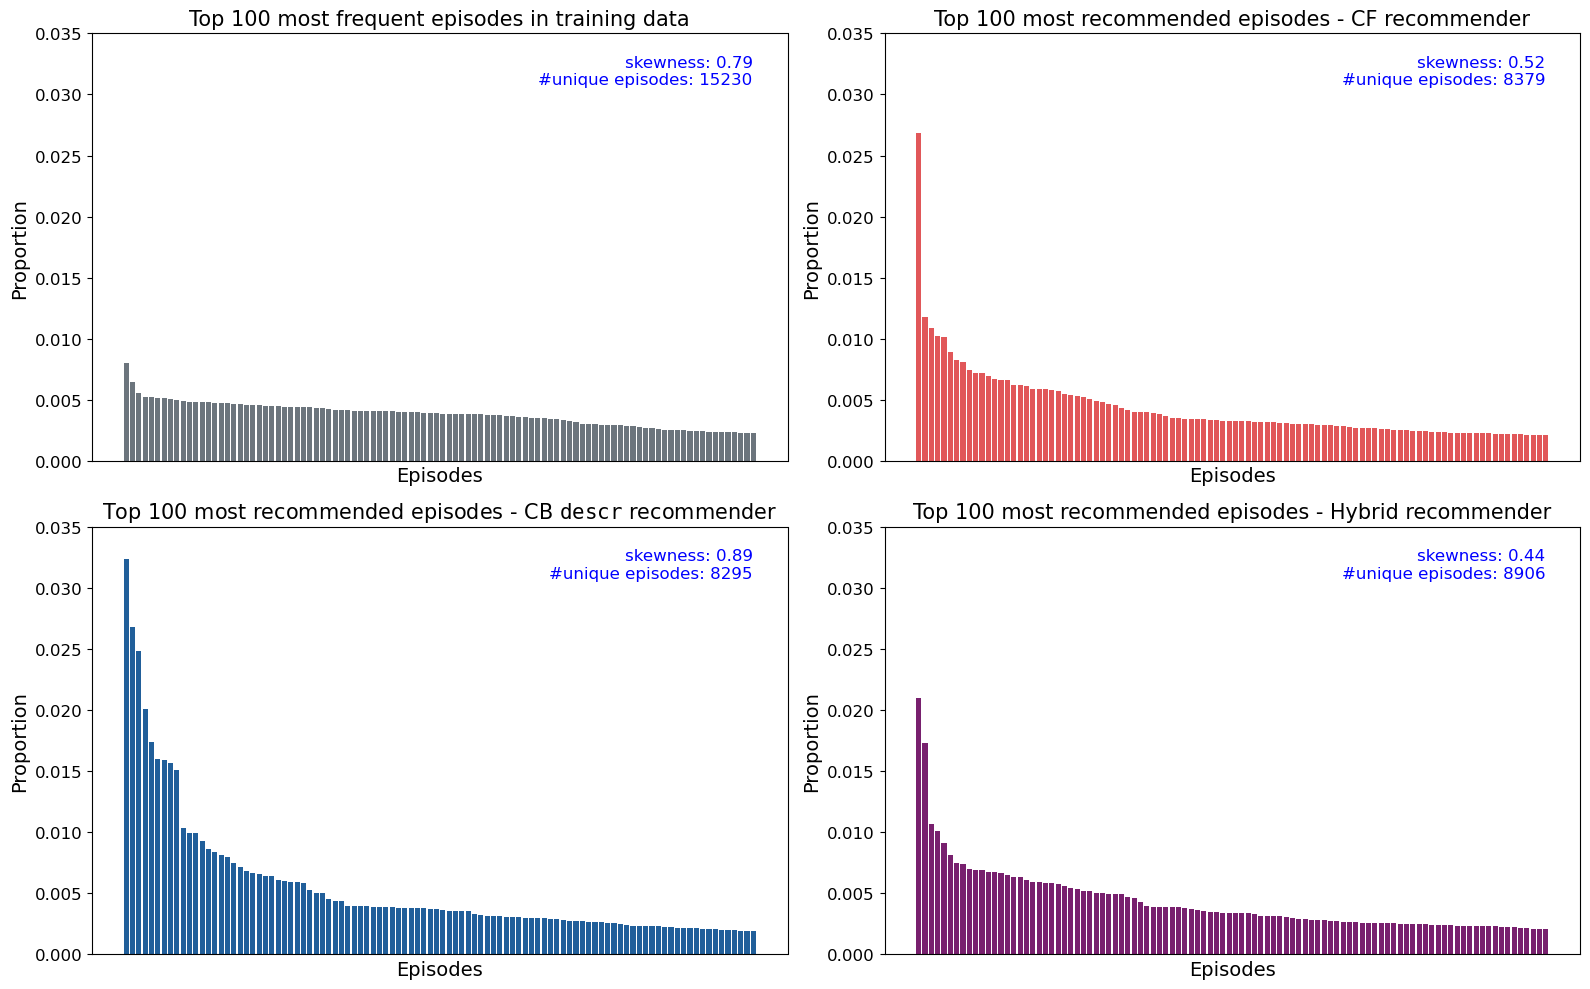

In [ ]:
# initializing subplot
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))

# dictionary to store skewness measures 
skew_dict = {}

# number of episodes to show in each bar chart
top_n = 100

for i, (recommender, color) in enumerate(color_mapping.items()):
    row = i // 2
    col = i % 2

    if i == 0:
        # occurences for each episode from the training data
        all_episodes = train_df["prd_number"]
        percentages = all_episodes.value_counts(normalize=True)

        # slicing according to top_n and converting to percentages
        top_episodes = percentages.head(top_n)
        labels = top_episodes.index.astype(str)
        percentages = top_episodes.values

    else:
        # retrieving list of recommendations from recs_data
        recommendations = recs_data[recommender]
        all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

        # counting the occurences for each episode and slicing according to top_n
        episode_counts = Counter(all_episodes)
        top_items = episode_counts.most_common(top_n)

        # extracting labels and values
        labels, values = zip(*top_items)

        # Compute total for relative frequency
        total = sum(episode_counts.values())
        percentages = [(v / total) for v in values]  

        # retrieving short recommender name
        rec_name = rec_names[recommender]

    # computing skewness
    prd_list = [int(prd) for prd in all_episodes]
    skewness = skew(prd_list)
    skew_dict[recommender] = skewness

    # computing number of unique episodes
    n_episodes = len(set(prd_list))

    # plotting the bar chart
    ax = axes[row][col]
    ax.bar(labels, percentages, color = color)

    # annotating the skewness and the number of unique episodes
    ax.annotate(f"skewness: {skewness:.2f}\n#unique episodes: {n_episodes}",
                            xy=(0.95, 0.95),
                            xycoords="axes fraction",
                            ha="right", va="top",
                            fontsize=12, color="blue"
                            )

    # formatting the plot
    if i == 0:
        ax.set_title(f"Top {top_n} most frequent episodes in training data", fontsize=15)
    else:
        ax.set_title(f"Top {top_n} most recommended episodes - {rec_name} recommender", fontsize=15)
    ax.set_xlabel("Episodes", fontsize=14)
    ax.set_ylabel("Proportion", fontsize=14)
    ax.set_ylim(0, 0.035)
    ax.set_xticks([],[])
    ax.tick_params(axis='y', labelsize=12) 

plt.tight_layout()
plt.show()

Measuring if the episode distributions among the recommendations are significantly more or less skewed than the training distribution.

In [ ]:
# setting seed for reproducibility
np.random.seed(RANDOM_STATE)

# list of possible episodes to draw and their probabilities from the training data
prd_col = train_df["prd_number"]
episode_counts = Counter(prd_col)
labels, values = zip(*episode_counts.items())

# converting prd numbers to integers
labels = [int(label) for label in labels]

# converting the counts to probabilities
total = sum(episode_counts.values())
probabilities = [v / total for v in values] 

# skewness of training distribution
train_skew = skew_dict["train"]

for recommender, rec_name in rec_names.items():
    # retrieving skewness of recommendations for recommender
    rec_skew = skew_dict[recommender]
    higher = train_skew < rec_skew
    skew_diffs = []
    print(f"Comparing training skewness ({train_skew:.3f}) with skewness of {rec_name} recommendations ({rec_skew:.3f}).")

    # printing the null and alternative hypothesis
    print("Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.")
    if higher:
        print("Alternative hypothesis: the skewness of the recommendations is significantly higher than the training skewness.")
    else:
        print("Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.")

    for _ in tqdm(range(n_iterations)):
        # sampling from training distribution
        sample = np.random.choice(labels, size=n_samples, p=probabilities)
        
        # measuring the skewness of the sample
        sample_skew = skew(sample)
        
        if higher:
            skew_diffs.append(sample_skew >= rec_skew)
        else:
            skew_diffs.append(sample_skew <= rec_skew)

    # computing and printing one-sided p-value
    p_value = np.mean(skew_diffs)
    print(f"One-sided p-value: {p_value:.10f}")

Comparing training skewness (0.789) with skewness of CF recommendations (0.521).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.


100%|██████████| 10000/10000 [06:59<00:00, 23.81it/s]


One-sided p-value: 0.0000000000
Comparing training skewness (0.789) with skewness of CB $\mathtt{descr}$ recommendations (0.893).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly higher than the training skewness.


100%|██████████| 10000/10000 [07:08<00:00, 23.33it/s]


One-sided p-value: 0.0000000000
Comparing training skewness (0.789) with skewness of Hybrid recommendations (0.436).
Null hypothesis: the skewness of the recommendations distribution is equivalent to the skewness of the training distribution of episodes, i.e. the distributions are equivalent.
Alternative hypothesis: the skewness of the recommendations is significantly lower than the training skewness.


100%|██████████| 10000/10000 [07:13<00:00, 23.09it/s]

One-sided p-value: 0.0000000000


### User Bias
Assessing performance metrics against the number of training interactions for each user. First and primarily for the evaluation metrics @10, but also @6 and @2 for the appendix.

In [87]:
# grouping by user_id and counting the number of unique prd_numbers for each user
user_counts = train_df.groupby("user_id")["prd_number"].nunique()

metric_names = {"hit_rate": "hit-rate",
                "ndcg": "NDCG",
                "diversity": "diversity"}

color_mapping_user_bias = {RECOMMENDATIONS_KEY_CF: "#E15759",
                           RECOMMENDATIONS_KEY_CB_DESCR: "#215F9A",
                           RECOMMENDATIONS_KEY_HYBRID: "#78206E"}

In [18]:
# function to compute R²
def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

c:\Users\sewr\AppData\Local\anaconda3\envs\dr-podcast-recsys\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\sewr\AppData\Local\anaconda3\envs\dr-podcast-recsys\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\sewr\AppData\Local\anaconda3\envs\dr-podcast-recsys\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\sewr\AppData\Local\anaconda3\envs\dr-podcast-recsys\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not

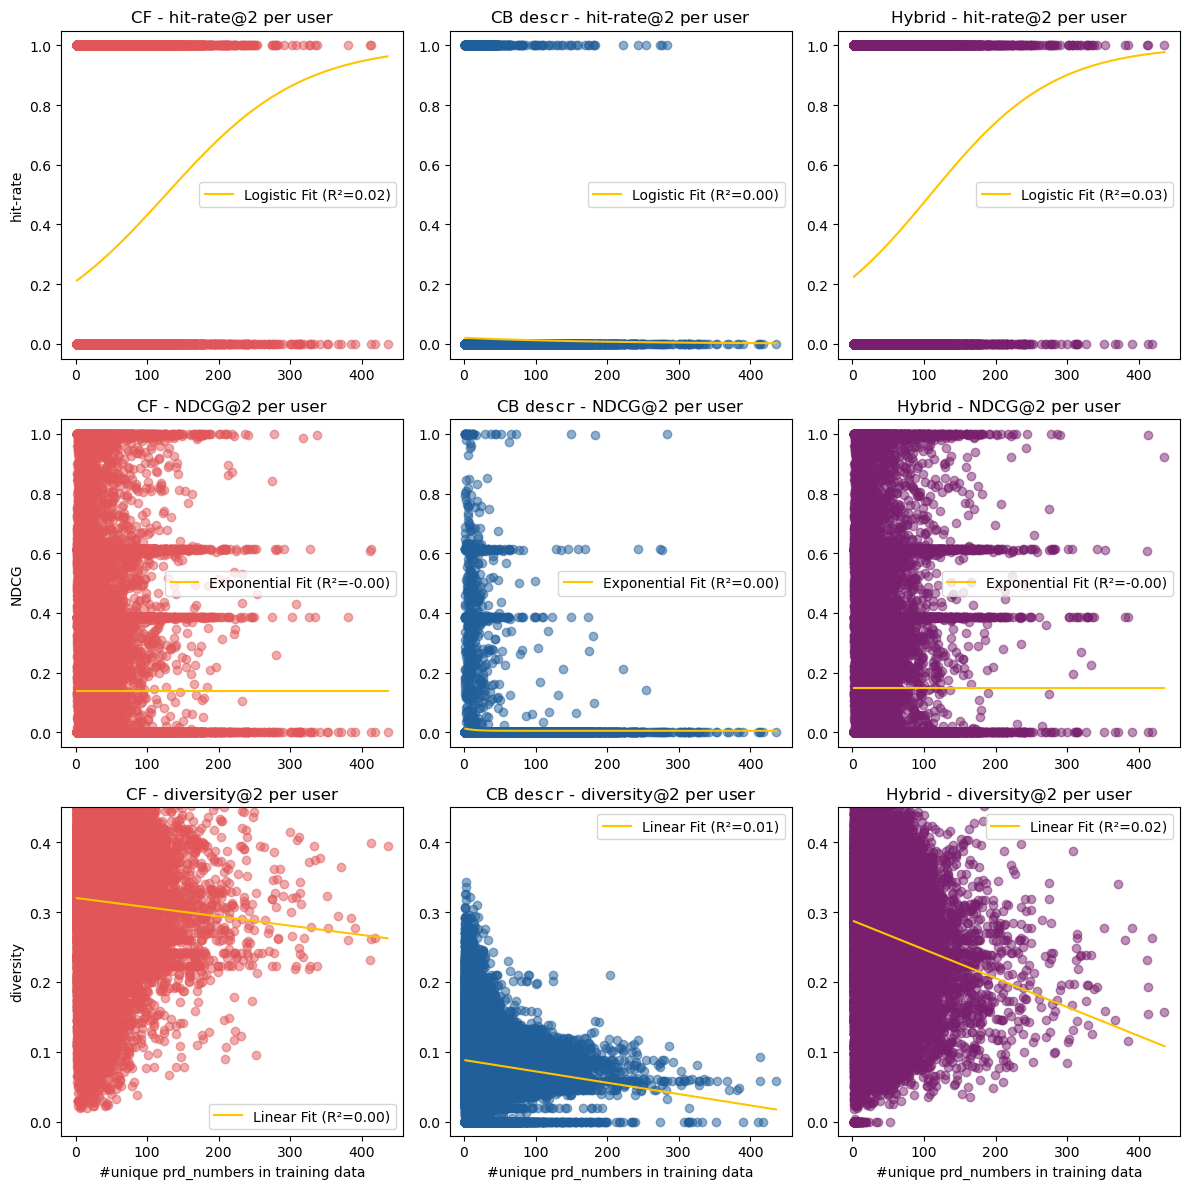

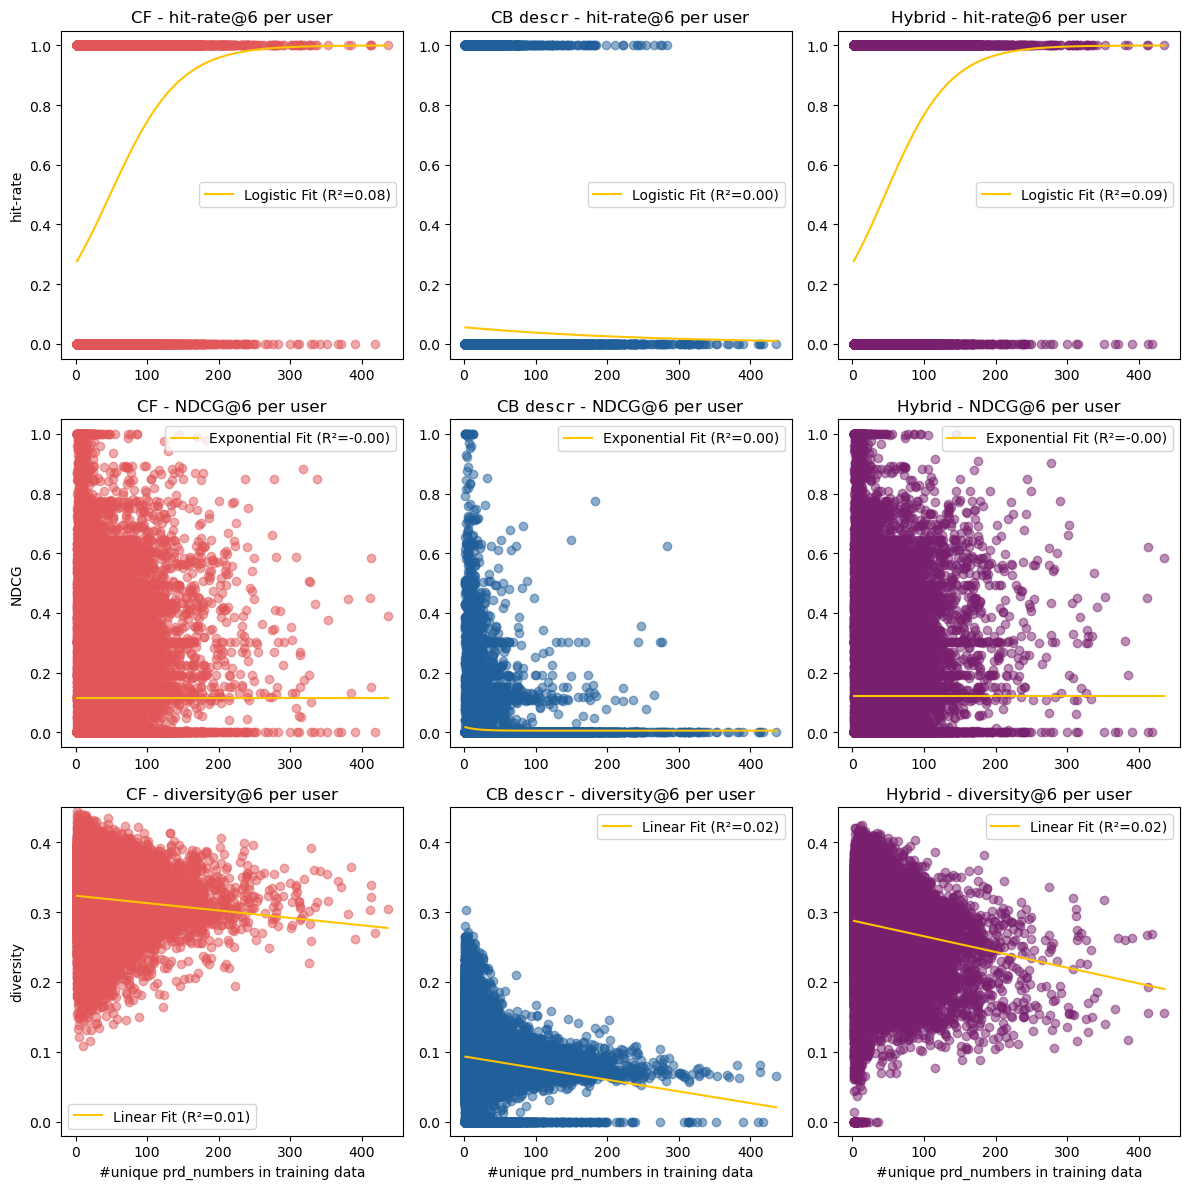

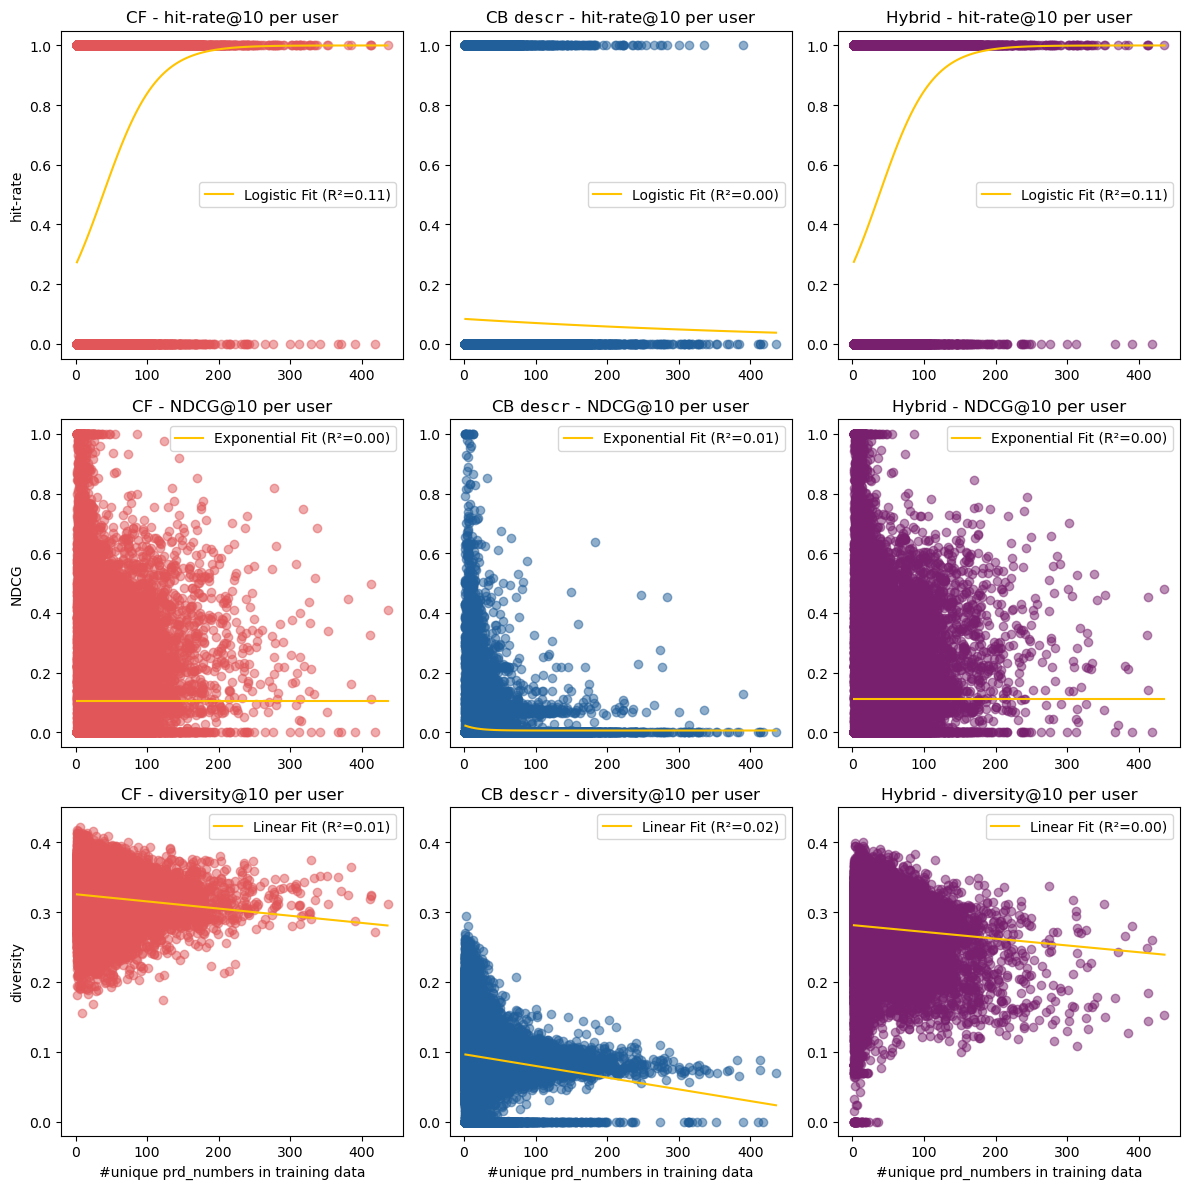

In [ ]:
for level, user_eval_data in levels.items():
    # initializing subplots
    n_metrics = len(EVALUATION_METRICS)
    n_recommenders = len(color_mapping_user_bias)
    fig, axes = plt.subplots(nrows=n_metrics, 
                             ncols=n_recommenders, 
                             figsize=(4*n_metrics, 4*n_recommenders))
    
    for i, (recommender, color) in enumerate(color_mapping_user_bias.items()):
        # recommender name
        rec_name = rec_names[recommender]
        
        # extracting the recommendations for the current recommender
        user_metrics = user_eval_data[recommender]

        # converting the user_metrics into a DataFrame
        user_metrics_df = pd.DataFrame(user_metrics).reset_index()
        user_metrics_df.columns = ["user_id"] + list(user_metrics.keys())

        # left joining the user_metrics_df with the user_counts
        merged_df = user_metrics_df.merge(user_counts.reset_index(), on="user_id", how="left")

        # removing outliers (2 users)
        merged_df_filtered = merged_df[merged_df["prd_number"] < 1000]

        # plotting each metric against the number of unique prd_numbers
        for j, metric in enumerate(EVALUATION_METRICS):
            # ax and metric name
            ax = axes[j][i]
            metric_name = metric_names[metric]

            # plotting the scatter plot
            x = merged_df_filtered["prd_number"].values
            y = merged_df_filtered[metric].values
            ax.scatter(x, y, alpha=0.5, color=color)
            
            # logistic regression fit for hit-rate
            if metric == "hit_rate":
                x_reshaped = x.reshape(-1, 1)
                logistic_model = LogisticRegression()
                logistic_model.fit(x_reshaped, y)
                x_vals = np.linspace(x_reshaped.min(), x_reshaped.max(), 100).reshape(-1, 1)
                y_vals = logistic_model.predict_proba(x_vals)[:, 1]

                # compute R²
                y_pred = logistic_model.predict_proba(x_reshaped)[:, 1]
                r2 = compute_r2(y, y_pred)

                # plot logistic fit
                ax.plot(x_vals, y_vals, color="#ffc300", label=f"Logistic Fit (R²={r2:.2f})")
            
            # exponential fit for ndcg
            elif metric == "ndcg":
                popt, _ = curve_fit(exponential_func, x, y)
                x_vals = np.linspace(x.min(), x.max(), 100)
                y_vals = exponential_func(x_vals, *popt)

                # compute R²
                y_pred = exponential_func(x, *popt)
                r2 = compute_r2(y, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="#ffc300", label=f"Exponential Fit (R²={r2:.2f})")

            # linear fit for diversity
            elif metric == "diversity":
                x_reshaped = x.reshape(-1, 1)
                linear_model = LinearRegression()
                linear_model.fit(x_reshaped, y)
                x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
                y_vals = linear_model.predict(x_vals)

                # compute R²
                y_pred = linear_model.predict(x_reshaped)
                r2 = compute_r2(y, y_pred)

                # plot linear fit
                ax.plot(x_vals, y_vals, color="#ffc300", label=f"Linear Fit (R²={r2:.2f})")

            # title, axis labels and legend
            ax.set_title(f"{rec_name} - {metric_name}@{level} per user")
            if j == 2:
                ax.set_xlabel("#unique prd_numbers in training data")
            if i == 0:
                ax.set_ylabel(metric_name) 
            ax.legend()

            # setting range on y-axis
            if j == 2:
                ax.set_ylim(-0.02, 0.45)
            else:
                ax.set_ylim(-0.05, 1.05)

    plt.tight_layout()

### Group Fairness of Genres
Distribution of genres in the training data and the recommendations:

In [90]:
# translating the genres to English
genre_translations = {"Aktualitet": "Current affairs",
                      "Børn": "Children",
                      "Dokumentar": "Documentary",
                      "Fakta og debat": "Factual & debate",
                      "Historie": "History",
                      "Kor og orkestre": "Choirs & orchestras",
                      "Kultur": "Culture",
                      "Livsstil": "Lifestyle",
                      "Musik": "Music",
                      "NN": "NN", 
                      "Nyheder": "News",
                      "Sport": "Sports",
                      "Underholdning": "Entertainment",
                      "Unge": "Youth"}
meta_df["genre"] = meta_df["genre"].replace(genre_translations)

# joining on metadata
train_w_meta_df = train_df.merge(meta_df.reset_index(), on="prd_number", how="left")

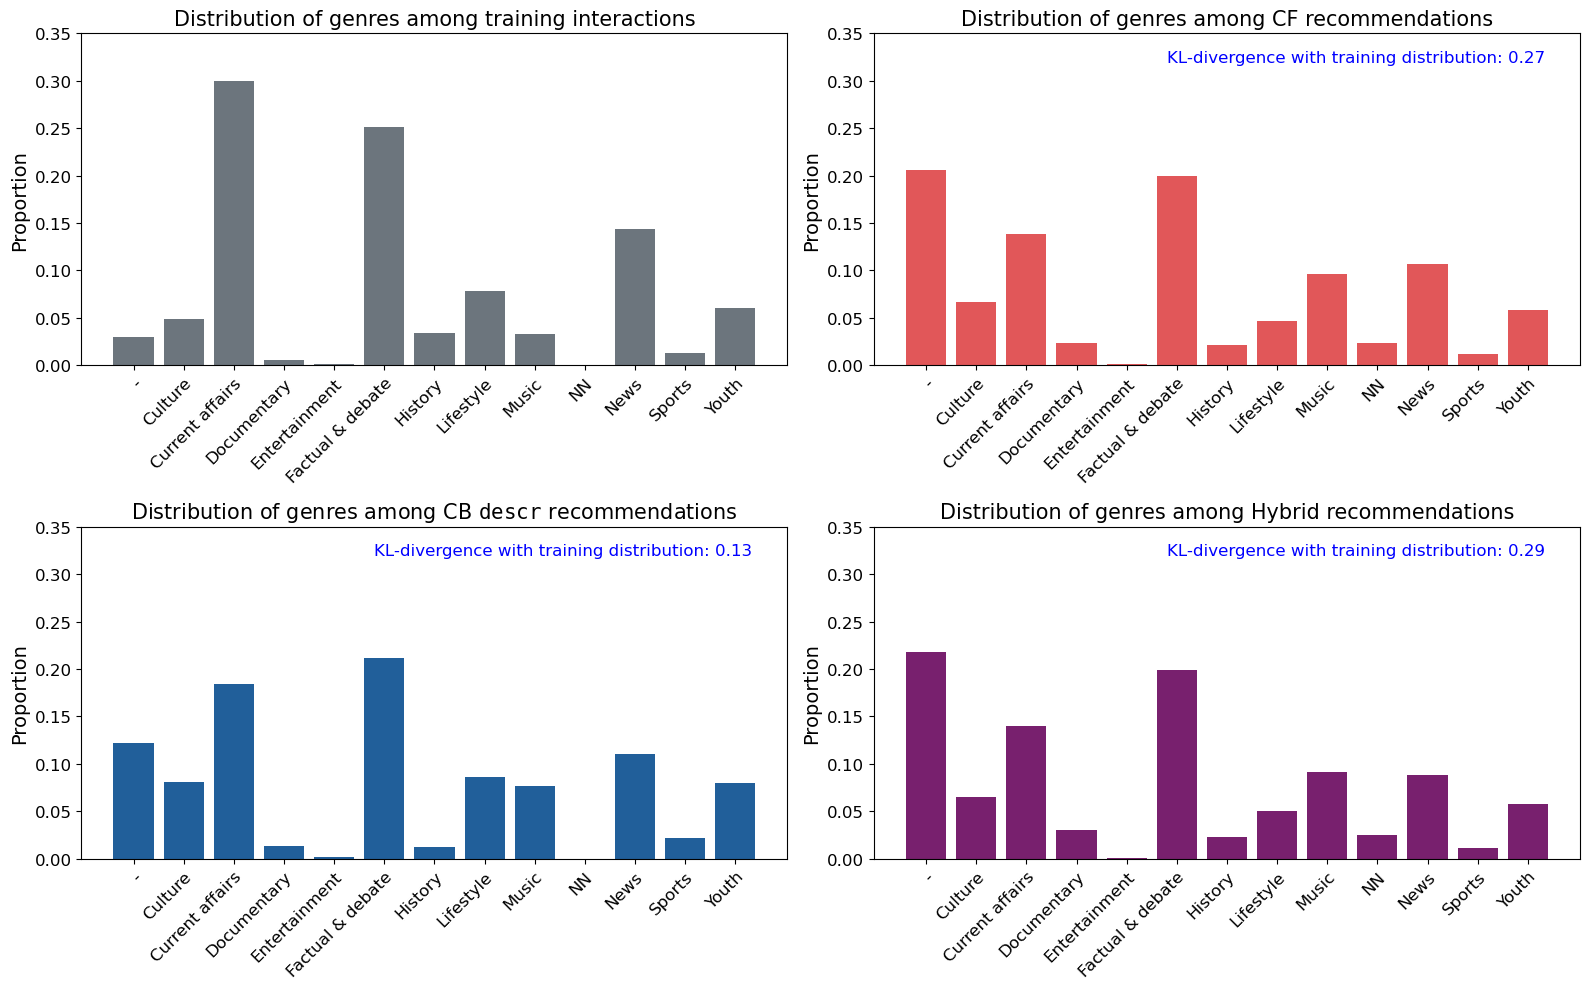

In [ ]:
# initializing subplot
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))

# dictionary to store KL-divergences
kl_dict = {}

for i, (recommender, color) in enumerate(color_mapping.items()):
    row = i // 2
    col = i % 2
    ax = axes[row][col]

    if i == 0:
        # genre distribution of training interactions
        train_genre_distr = train_w_meta_df["genre"].value_counts(normalize=True)
        train_genre_distr_sorted = train_genre_distr.sort_index()
        genres = train_genre_distr_sorted.index.astype(str)
        percentages = train_genre_distr_sorted.values
        training_distr = percentages
    
    else:
        # retrieving list of recommendations from recs_data
        recommendations = recs_data[recommender]
        all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

        # constructing dataframe
        df = pd.DataFrame({"prd_number": all_episodes})

        # joining metadata onto the dataframe
        df_w_meta = df.merge(meta_df.reset_index(), on="prd_number", how="left")

        # genre distribution of recommendations
        rec_genre_distr = df_w_meta["genre"].value_counts(normalize=True)
        rec_genre_distr_sorted =  rec_genre_distr.sort_index()
        genres = rec_genre_distr_sorted.index.astype(str)
        percentages = rec_genre_distr_sorted.values

        # computing KL-divergence
        kl_div = entropy(training_distr, percentages)
        kl_dict[recommender] = kl_div
        
        # annotating the skewness and the number of unique episodes
        ax.annotate(f"KL-divergence with training distribution: {kl_div:.2f}",
                                xy=(0.95, 0.95),
                                xycoords="axes fraction",
                                ha="right", va="top",
                                fontsize=12, color="blue"
                                )
            
        # retrieving recommender name
        rec_name = rec_names[recommender]

    # measuring the distribution
    if i == 0:
        ax.set_title("Distribution of genres among training interactions", fontsize=15)
    else:
        ax.set_title(f"Distribution of genres among {rec_name} recommendations", fontsize=15)
    ax.bar(range(len(genres)), percentages, color=color)
    ax.set_ylabel("Proportion", fontsize=14)
    ax.set_ylim(0, 0.35)
    ax.set_xticks(range(len(genres)))  
    ax.set_xticklabels(genres, rotation=45, ha="right", rotation_mode="anchor", fontsize=12)  
    ax.tick_params(axis="y", labelsize=12) 

plt.tight_layout()

Measuring if the KL-divergences signify that the genre distributions of the recommendations are significantly different from the genre distribution of the training interactions.

In [ ]:
# setting seed for reproducibility
np.random.seed(RANDOM_STATE)

# genre distribution of training interactions
train_genre_distr = train_w_meta_df["genre"].value_counts(normalize=True)
train_genre_distr_sorted = train_genre_distr.sort_index()
genres = train_genre_distr_sorted.index.astype(str)
probabilities = train_genre_distr_sorted.values

for recommender in rec_names.keys():
    # retrieving skewness of recommendations for recommender
    rec_kl = kl_dict[recommender]
    rec_name = rec_names[recommender]
    kl_diffs = []
    print(f"Testing if the genre distribution of {rec_name} recommendations is significantly different from the genre distribution of the training interactions.")
    print(f"Observed KL-divergence for {rec_name} recommender: {rec_kl:.2f}")

    # printing the null and alternative hypothesis
    print(f"Null hypothesis: the genre distribution of the {rec_name} recommendations is the same as the genre distribution of the training interactions.")
    print(f"Alternative hypothesis: the genre distribution of the {rec_name} recommendations is different from the genre distribution of the training interactions.")
    print(f"In other words: the observed KL-divergence is large enough to imply that")

    for _ in tqdm(range(n_iterations)):
        # sampling from training distribution
        sample = np.random.choice(genres, size=n_samples, p=probabilities)

        # computing sampling distribution
        counts = Counter(sample)
        total = sum(counts.values())
        distribution = dict(sorted((k, v / total) for k, v in counts.items()))
        distribution = list(distribution.values())

        # measuring the skewness of the sample
        sample_kl = entropy(probabilities, distribution)
        kl_diffs.append(sample_kl >= rec_kl)

    # computing and printing one-sided p-value
    p_value = np.mean(kl_diffs)
    print(f"One-sided p-value: {p_value:.10f}")

Testing if the genre distribution of CF recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for CF recommender: 0.27
Null hypothesis: the genre distribution of the CF recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the CF recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [04:50<00:00, 34.48it/s]


One-sided p-value: 0.0000000000
Testing if the genre distribution of CB $\mathtt{descr}$ recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for CB $\mathtt{descr}$ recommender: 0.13
Null hypothesis: the genre distribution of the CB $\mathtt{descr}$ recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the CB $\mathtt{descr}$ recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [04:39<00:00, 35.76it/s]


One-sided p-value: 0.0000000000
Testing if the genre distribution of Hybrid recommendations is significantly different from the genre distribution of the training interactions.
Observed KL-divergence for Hybrid recommender: 0.29
Null hypothesis: the genre distribution of the Hybrid recommendations is the same as the genre distribution of the training interactions.
Alternative hypothesis: the genre distribution of the Hybrid recommendations is different from the genre distribution of the training interactions.
In other words: the observed KL-divergence is large enough to imply that


100%|██████████| 10000/10000 [05:10<00:00, 32.16it/s]

One-sided p-value: 0.0000000000


### Additional plots for presentation
Number of test interactions for each user plotted against hit-rate and NDCG.

In [12]:
# grouping by user_id and counting the number of unique prd_numbers for each user
user_counts = test_df.groupby("user_id")["prd_number"].nunique()

metric_names = {"hit_rate": "hit-rate",
                "ndcg": "NDCG"}

color_mapping_user_bias = {RECOMMENDATIONS_KEY_CF: "#E15759",
                           RECOMMENDATIONS_KEY_CB_DESCR: "#215F9A",
                           RECOMMENDATIONS_KEY_HYBRID: "#78206E"}

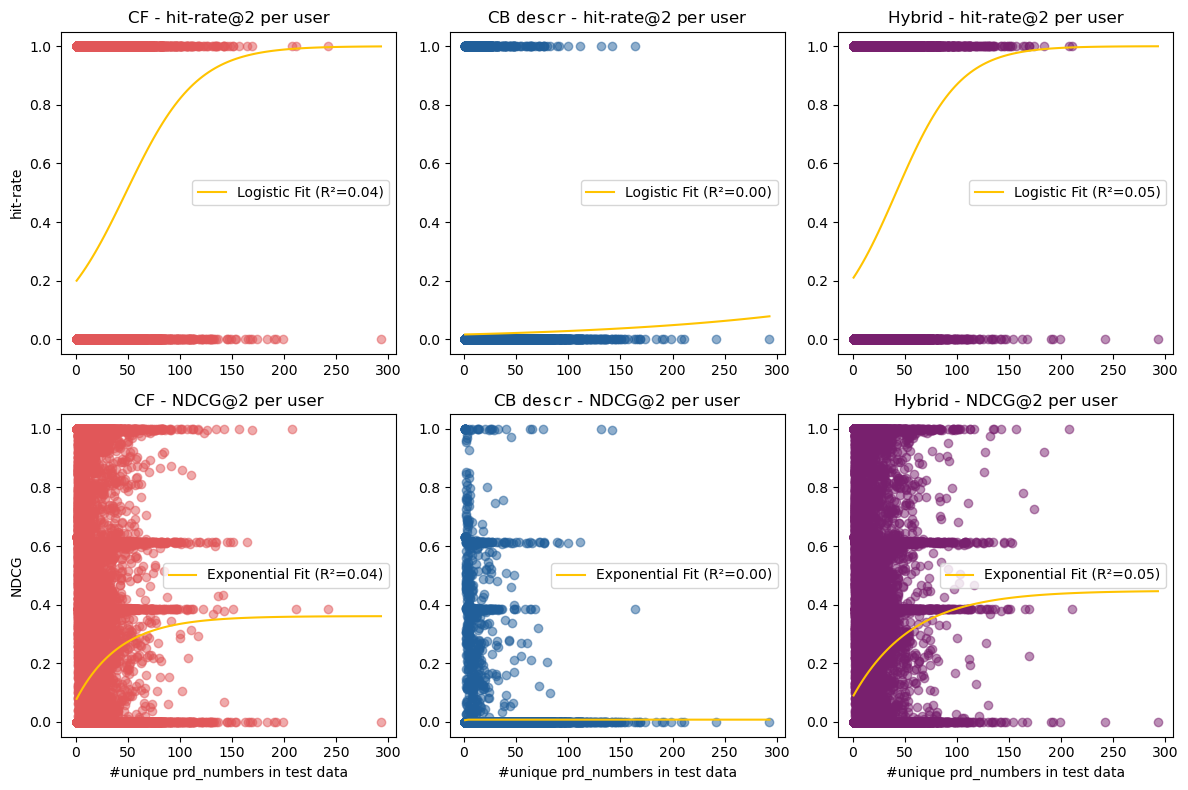

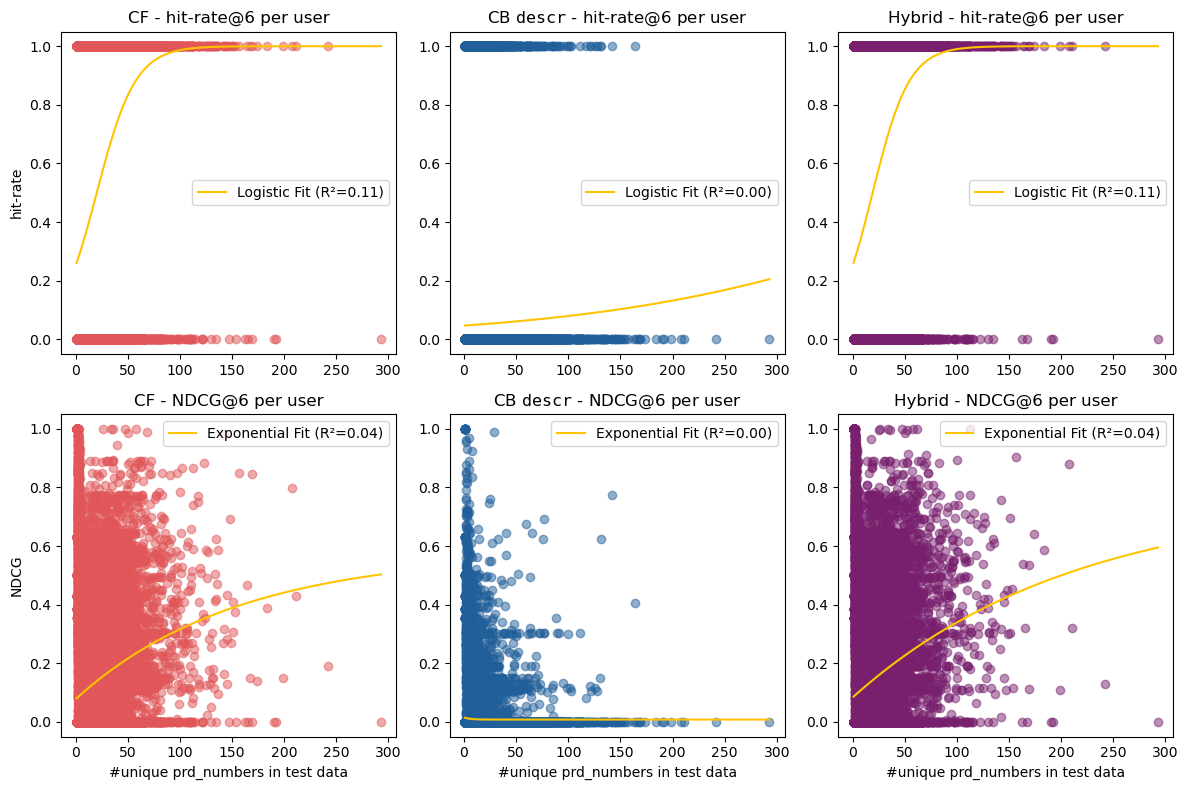

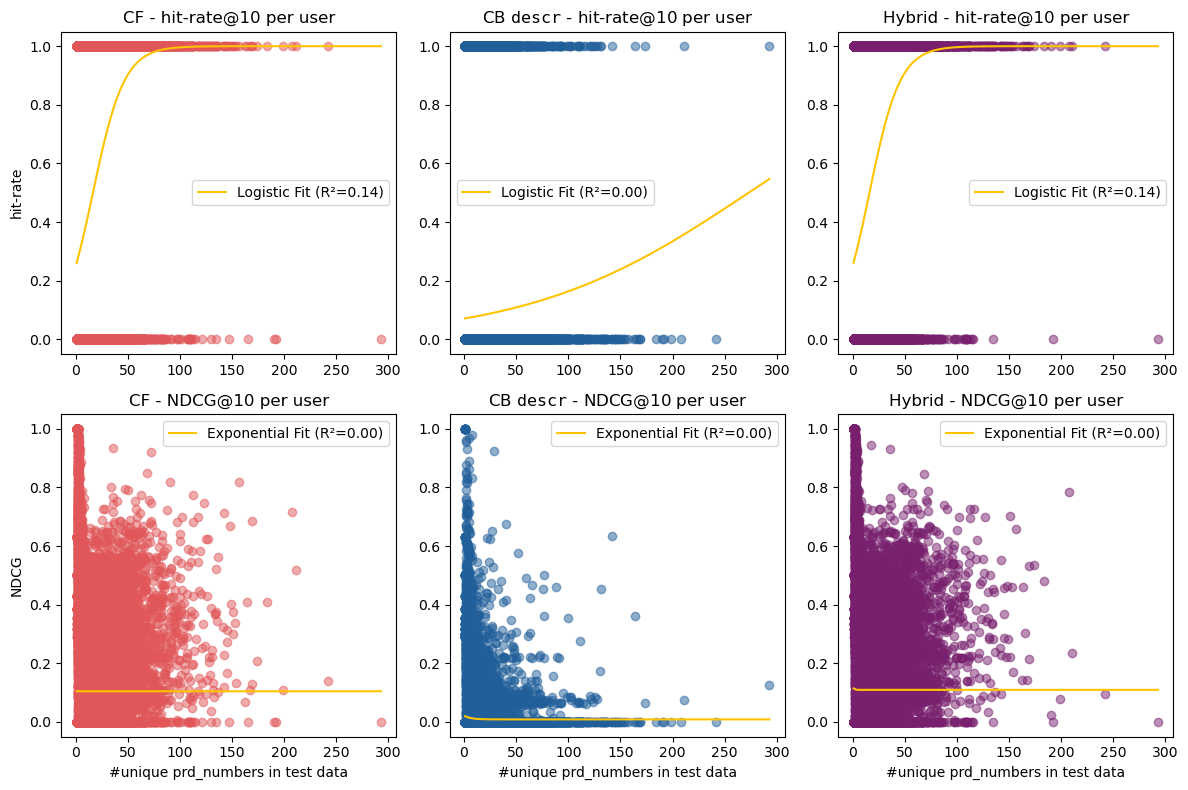

In [19]:
for level, user_eval_data in levels.items():
    # initializing subplots
    n_metrics = len(metric_names)
    n_recommenders = len(color_mapping_user_bias)
    fig, axes = plt.subplots(nrows=n_metrics, 
                             ncols=n_recommenders, 
                             figsize=(4*n_recommenders, 4*n_metrics))
    
    for i, (recommender, color) in enumerate(color_mapping_user_bias.items()):
        # recommender name
        rec_name = rec_names[recommender]
        
        # extracting the recommendations for the current recommender
        user_metrics = user_eval_data[recommender]

        # converting the user_metrics into a DataFrame
        user_metrics_df = pd.DataFrame(user_metrics).reset_index()
        user_metrics_df.columns = ["user_id"] + list(user_metrics.keys())

        # left joining the user_metrics_df with the user_counts
        merged_df = user_metrics_df.merge(user_counts.reset_index(), on="user_id", how="left")

        # removing outliers (2 users)
        merged_df_filtered = merged_df[merged_df["prd_number"] < 300]

        # plotting each metric against the number of unique prd_numbers
        for j, metric in enumerate(metric_names.keys()):
            # ax and metric name
            ax = axes[j][i]
            metric_name = metric_names[metric]

            # plotting the scatter plot
            x = merged_df_filtered["prd_number"].values
            y = merged_df_filtered[metric].values
            ax.scatter(x, y, alpha=0.5, color=color)
            
            # logistic regression fit for hit-rate
            if metric == "hit_rate":
                x_reshaped = x.reshape(-1, 1)
                logistic_model = LogisticRegression()
                logistic_model.fit(x_reshaped, y)
                x_vals = np.linspace(x_reshaped.min(), x_reshaped.max(), 100).reshape(-1, 1)
                y_vals = logistic_model.predict_proba(x_vals)[:, 1]

                # compute R²
                y_pred = logistic_model.predict_proba(x_reshaped)[:, 1]
                r2 = compute_r2(y, y_pred)

                # plot logistic fit
                ax.plot(x_vals, y_vals, color="#ffc300", label=f"Logistic Fit (R²={r2:.2f})")
            
            # exponential fit for ndcg
            elif metric == "ndcg":
                popt, _ = curve_fit(exponential_func, x, y)
                x_vals = np.linspace(x.min(), x.max(), 100)
                y_vals = exponential_func(x_vals, *popt)

                # compute R²
                y_pred = exponential_func(x, *popt)
                r2 = compute_r2(y, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="#ffc300", label=f"Exponential Fit (R²={r2:.2f})")

            # title, axis labels and legend
            ax.set_title(f"{rec_name} - {metric_name}@{level} per user")
            if j == 1:
                ax.set_xlabel("#unique prd_numbers in test data")
            if i == 0:
                ax.set_ylabel(metric_name) 
            ax.legend()

    plt.tight_layout()

Plotting average completion rate per episode length to see if the completion rate tends to be higher for shorter episodes.

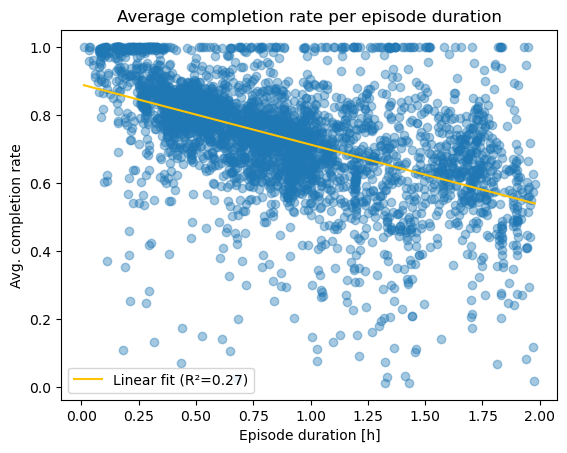

In [47]:
# joining metadata onto the training data
train_w_meta = pd.merge(train_df, meta_df, on="prd_number", how="left")
train_w_meta["duration_hour"] = train_w_meta["episode_duration"] / 60**2
train_w_meta = train_w_meta[train_w_meta["duration_hour"] < 2]

# grouping by episode_length
grouped = train_w_meta.groupby("duration_hour")

# computing the average completion rate for each episode duration
result = grouped["completion_rate"].mean()

# plotting the average completion rates against the episode durations
plt.scatter(result.index, result.values, alpha=0.4)
x = np.array(result.index).reshape(-1, 1)
y = result.values

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
r2 = model.score(x, y)

# plot regression line
plt.plot(result.index, y_pred, color="#ffc300", label=f"Linear fit (R²={r2:.2f})")

plt.title("Average completion rate per episode duration")
plt.xlabel("Episode duration [h]")
plt.ylabel("Avg. completion rate")
plt.legend()